# __Transfer Learning - (MXNet)__

## __Setting up Kaggle credentials__

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## __Downloading dataset from kaggle__

We will train our model for the dataset containing natural images of flowers, dog, cat... etc

In [0]:
!mkdir dataset
!pwd
%cd dataset
!kaggle datasets download prasunroy/natural-images
!unzip natural-images.zip
%cd ..

## __Importing required frameworks__

In [0]:
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
from mxnet.gluon.data import vision
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
import os

plt.style.use('seaborn')

ctx = mx.gpu()

## __Creating directories for validation and testing datasets__

In [7]:
train_root = "dataset/natural_images/"
val_root = "dataset/val/"
test_root = "dataset/test/"

os.mkdir(val_root)
os.mkdir(test_root)

categories = os.listdir(train_root)
categories.sort()

print("Categories:", categories)
print("Total Categories:", len(categories))

for category in categories:
    os.mkdir(os.path.join(val_root, category))    
    os.mkdir(os.path.join(test_root, category))
    print(f"{len(os.listdir(train_root + category))} images for '{category}' category")

Categories: ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
Total Categories: 8
727 images for 'airplane' category
968 images for 'car' category
885 images for 'cat' category
702 images for 'dog' category
843 images for 'flower' category
1000 images for 'fruit' category
788 images for 'motorbike' category
986 images for 'person' category


## __Creating validation and testing datasets__

- 50 images per category in validation dataset

- And 150 images per category in testing dataset

In [8]:
for category in categories:
    print(f"Creating validation and testing dataset for '{category}' category")
    for _ in range(10):
        images = os.listdir(train_root + category)
        idx = int(nd.random.randint(0, len(images)).asscalar())
        image = images[idx]
        os.rename(os.path.join(train_root, category, image), os.path.join(val_root, category, image))

    for _ in range(150):
        images = os.listdir(train_root + category)
        idx = int(nd.random.randint(0, len(images)).asscalar())
        image = images[idx]
        os.rename(os.path.join(train_root, category, image), os.path.join(test_root, category, image))

Creating validation and testing dataset for 'airplane' category
Creating validation and testing dataset for 'car' category
Creating validation and testing dataset for 'cat' category
Creating validation and testing dataset for 'dog' category
Creating validation and testing dataset for 'flower' category
Creating validation and testing dataset for 'fruit' category
Creating validation and testing dataset for 'motorbike' category
Creating validation and testing dataset for 'person' category


## __Visualizing examples counts per category in training, validation and testing datasets__

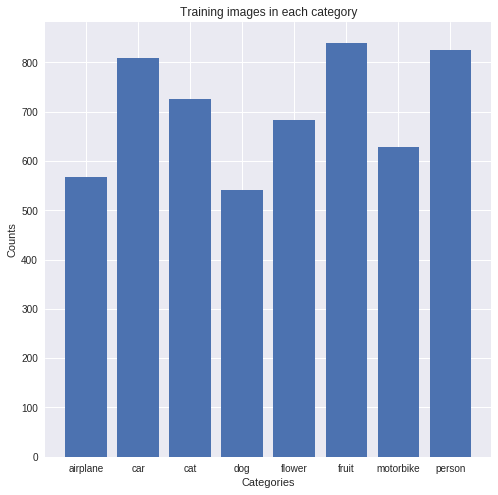

In [9]:
train_counts = []
for category in categories:
    train_counts.append(len(os.listdir(train_root + category)))
plt.figure(figsize = (8,8))
plt.bar(categories, train_counts)
plt.title('Training images in each category')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

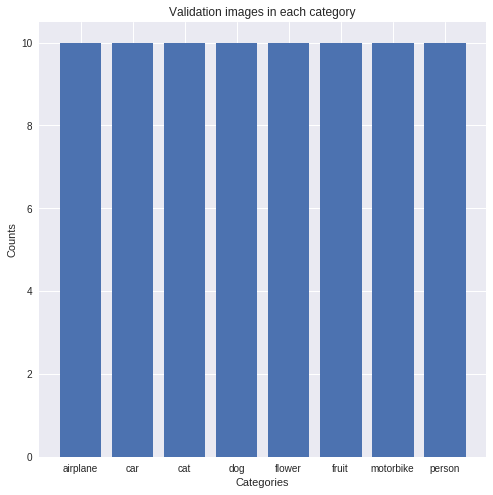

In [10]:
val_counts = []
for category in categories:
    val_counts.append(len(os.listdir(val_root + category)))
plt.figure(figsize = (8,8))
plt.bar(categories, val_counts)
plt.title('Validation images in each category')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

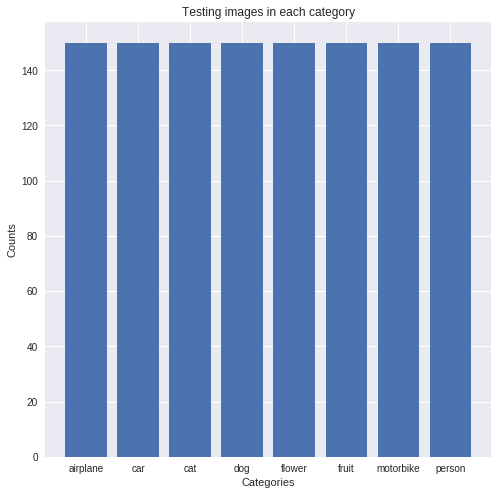

In [11]:
test_counts = []
for category in categories:
    test_counts.append(len(os.listdir(test_root + category)))
plt.figure(figsize = (8,8))
plt.bar(categories, test_counts)
plt.title('Testing images in each category')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

## __Doing data augmentation and defining data loaders__

In [12]:
train_transform = vision.transforms.Compose([vision.transforms.RandomSaturation(saturation = 0.1),
                                vision.transforms.RandomLighting(alpha = 0.2),
                                vision.transforms.RandomHue(hue = 0.1),
                                vision.transforms.RandomFlipLeftRight(),
                                vision.transforms.RandomContrast(contrast = 0.2),
                                vision.transforms.RandomColorJitter(brightness = 0.1, contrast = 0.1, saturation = 0.1, hue = 0.1),
                                vision.transforms.Resize(128),
                                vision.transforms.ToTensor()])

transform = vision.transforms.Compose([vision.transforms.Resize(128),
                                       vision.transforms.ToTensor()])

batch_size = 64

train_data = gluon.data.DataLoader(
                vision.ImageFolderDataset(root = train_root, flag = 1).transform_first(train_transform),
                batch_size = batch_size, shuffle = True)

val_data = gluon.data.DataLoader(
                vision.ImageFolderDataset(root = val_root, flag = 1).transform_first(transform),
                batch_size = batch_size, shuffle = False)

test_data = gluon.data.DataLoader(
                vision.ImageFolderDataset(root = test_root, flag = 1).transform_first(transform),
                batch_size = batch_size, shuffle = False)

print(f"{len(train_data)} batches in training data")
print(f"{len(val_data)} batches in validation data")
print(f"{len(test_data)} batches in testing data")

88 batches in training data
2 batches in validation data
19 batches in testing data


## __Making sure that our datasets are normalized__

In [13]:
for features, labels in train_data:
    break

print(f"features.shape: {features.shape}")
print(f"labels.shape: {labels.shape}")

print(f"features.max(): {features.max().asscalar()}")
print(f"features.min(): {features.min().asscalar()}")

features.shape: (64, 3, 128, 128)
labels.shape: (64,)
features.max(): 1.0
features.min(): 0.0


## __Visializing sample images of our training dataset__

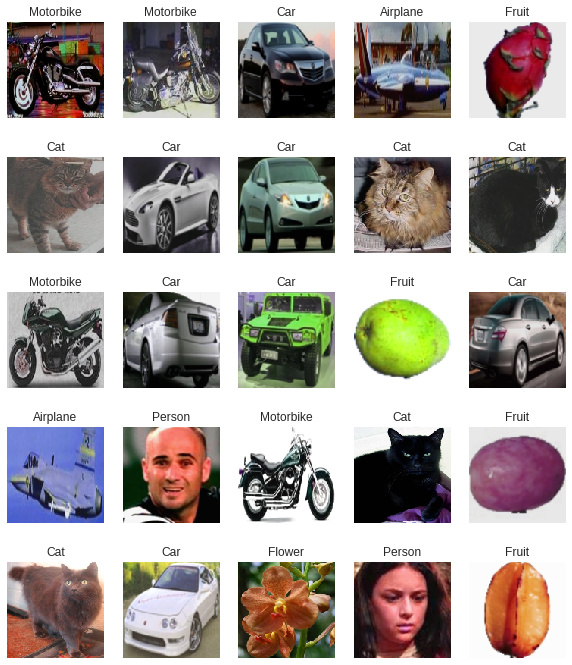

In [14]:
plt.figure(figsize = (10, 12))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(features[i].transpose((1, 2, 0)).asnumpy())
    plt.title(categories[int(labels[i].asscalar())].title())
    plt.axis("off")
plt.show()

## __Loading pretrained model(MobileNet) and updating the last layers__

Note the fact that parameters of all layers except the last dense layer are pretrained on ImageNet dataset... Only last dense layer is initialized randomly. This is know as Transfer Learning.



In [15]:
model = gluon.model_zoo.vision.mobilenet_v2_1_0(pretrained = True, ctx = ctx)

with model.name_scope():
    model.output.add(nn.Dropout(0.5))
    model.output.add(nn.Dense(len(categories)))
model.output.initialize(mx.init.Xavier(), ctx = ctx)

print(model)

MobileNetV2(
  (features): HybridSequential(
    (0): Conv2D(3 -> 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
    (2): RELU6(
    
    )
    (3): LinearBottleneck(
      (out): HybridSequential(
        (0): Conv2D(32 -> 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
        (2): RELU6(
        
        )
        (3): Conv2D(1 -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
        (5): RELU6(
        
        )
        (6): Conv2D(32 -> 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=16)

/usr/local/lib/python3.6/dist-packages/mxnet/gluon/parameter.py:862: UserWarning: Parameter 'mobilenetv20_output_pred_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)


## __Visualizing model architecture__

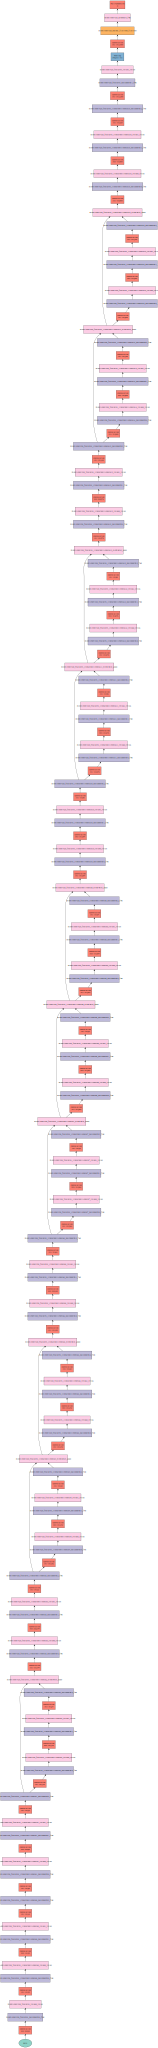

In [16]:
mx.viz.plot_network(model(mx.sym.var(name = 'data')), node_attrs = {'fixedsize': 'false'},)

## __Summarizing model layers__

In [17]:
model.summary(features.as_in_context(ctx))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                           (64, 3, 128, 128)               0
            Conv2D-1                            (64, 32, 64, 64)             864
         BatchNorm-2                            (64, 32, 64, 64)             128
             RELU6-3                            (64, 32, 64, 64)               0
            Conv2D-4                            (64, 32, 64, 64)            1024
         BatchNorm-5                            (64, 32, 64, 64)             128
             RELU6-6                            (64, 32, 64, 64)               0
            Conv2D-7                            (64, 32, 64, 64)             288
         BatchNorm-8                            (64, 32, 64, 64)             128
             RELU6-9                            (64, 32, 64, 64)               0
           Conv2D-10        

## __Hybridizing and defining objective loss and optimizer__

In [0]:
model.hybridize()
objective = gluon.loss.SoftmaxCrossEntropyLoss()
optimizer = mx.optimizer.Adam(learning_rate = 0.0005)
trainer = gluon.Trainer(model.collect_params(), optimizer)
metric = mx.metric.Accuracy()

## __Training the model__

In [19]:
epochs = 10
batches = len(train_data)

train_losses = []
train_accs = []
val_losses = []
val_accs = []

best_val = 0.0

for epoch in range(epochs):
    metric.reset()
    cum_loss = 0.0
    for features, labels in tqdm(train_data, desc = f'Epoch: {epoch + 1} Completed', ncols = 800):
        features = features.as_in_context(ctx)
        labels = labels.as_in_context(ctx)

        with autograd.record():
            outputs = model(features)
            loss = objective(outputs, labels)
        loss.backward()
        trainer.step(batch_size)

        cum_loss += loss.mean()
        metric.update(labels, outputs)

    train_loss = cum_loss.asscalar()/batches
    train_acc = metric.get()[1]

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    metric.reset()
    cum_loss = 0.0
    for features, labels in test_data:
        features = features.as_in_context(ctx)
        labels = labels.as_in_context(ctx)
        outputs = model(features)
        metric.update(labels, outputs)
        cum_loss += objective(outputs, labels).mean()

    val_loss = cum_loss.asscalar()/batches
    val_acc = metric.get()[1]

    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f'Training Loss:\t {train_loss:.5f} | Training Accuracy:   {train_acc:.5f}')
    print(f'Validation Loss: {val_loss:.5f} | Validation Accuracy: {val_acc:.5f}')
    if val_acc > best_val:
        print('Saving model for best validation accuracy')
        model.save_parameters('model.params')
        best_val = val_acc


Training Loss:	 0.54156 | Training Accuracy:   0.93255
Validation Loss: 0.01529 | Validation Accuracy: 0.98750
Saving model for best validation accuracy



Training Loss:	 0.13175 | Training Accuracy:   0.97402
Validation Loss: 0.00745 | Validation Accuracy: 0.98417



Training Loss:	 0.06810 | Training Accuracy:   0.98309
Validation Loss: 0.00858 | Validation Accuracy: 0.98833
Saving model for best validation accuracy



Training Loss:	 0.08514 | Training Accuracy:   0.98416
Validation Loss: 0.00759 | Validation Accuracy: 0.98667



Training Loss:	 0.06990 | Training Accuracy:   0.98754
Validation Loss: 0.00998 | Validation Accuracy: 0.98833



Training Loss:	 0.05332 | Training Accuracy:   0.98808
Validation Loss: 0.00619 | Validation Accuracy: 0.98667



Training Loss:	 0.03759 | Training Accuracy:   0.99003
Validation Loss: 0.00570 | Validation Accuracy: 0.99250
Saving model for best validation accuracy



Training Loss:	 0.01479 | Training Accuracy:   0.99591
Validation Loss: 0.00314 | Validation Accuracy: 0.99333
Saving model for best validation accuracy



Training Loss:	 0.00723 | Training Accuracy:   0.99697
Validation Loss: 0.01330 | Validation Accuracy: 0.98583



Training Loss:	 0.04070 | Training Accuracy:   0.99092
Validation Loss: 0.00409 | Validation Accuracy: 0.99250


## __Plotting accuracies for training and validation datasets__ 

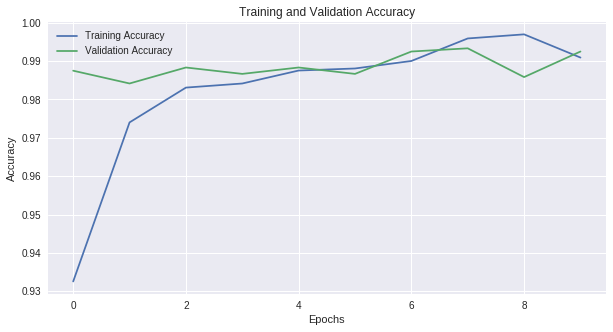

In [20]:
plt.figure(figsize = (10, 5))
plt.plot(train_accs, label = 'Training Accuracy')
plt.plot(val_accs, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## __Plotting losses for training and validation datasets__ 

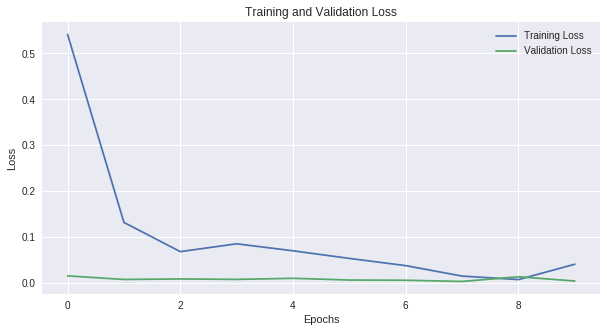

In [21]:
plt.figure(figsize = (10, 5))
plt.plot(train_losses, label = 'Training Loss')
plt.plot(val_losses, label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## __Initializing the model parameters with best validation accuracy__

In [0]:
model.load_parameters('model.params')

## __Testing the model__

In [23]:
metric.reset()
for features, labels in test_data:
    features = features.as_in_context(ctx)
    labels = labels.as_in_context(ctx)
    outputs = model(features)
    metric.update(labels, outputs)
print(f'Testing Accuracy: {metric.get()[1]}')

Testing Accuracy: 0.9933333333333333


## __Testing the model for top 2 accuracy metric__

Top k(and k is 2 in our case) accuracy is defined as - if the correct image label is in top k probabilities given by the model then it is counted as correct:

For example... for top 2 accuracy, if the correct class label is 3, then if the probability of the third output neuron is 2nd highest or 1st... it is counted as correct, other wise wrong.

## __And below it looks like our model is performing 100% for top 2 accuracy metric__

This implies that if the output neuron with highest probability of the model for an input image is wrong prediction, then the neuron with second highest probability will always be 100% correct!!

Note that this above statement is only true for the testing dataset

In [34]:
top2 = mx.metric.TopKAccuracy(top_k = 2)
top2.reset()
for features, labels in test_data:
    features = features.as_in_context(ctx)
    labels = labels.as_in_context(ctx)
    outputs = model(features)
    top2.update(labels, outputs)
print(f'Testing Top-2 Accuracy: {top2.get()[1]}')

Testing Top-2 Accuracy: 1.0


## __Now lets see how our model performs for random images from the internet!__

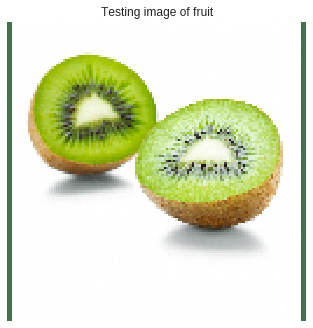

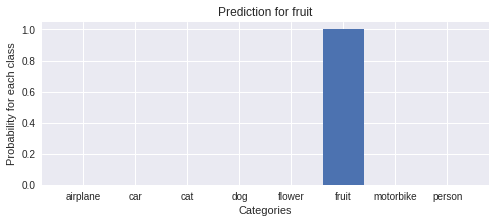

In [47]:
fruit = gluon.utils.download(url = "https://www.diabete.qc.ca/wp-content/uploads/2014/08/Les-fruits.png")
image = transform(mx.image.imread(fruit, flag = 1))
plt.imshow(image.transpose((1, 2, 0)).asnumpy())
plt.title('Testing image of fruit')
plt.axis('off')
plt.show()


prediction = model(image.expand_dims(0).as_in_context(ctx)).softmax().asnumpy()[0]

probs = []
for prob in prediction:
    probs.append(prob)
plt.figure(figsize = (8,3))
plt.bar(categories, probs)
plt.title('Prediction for fruit')
plt.xlabel('Categories')
plt.ylabel('Probability for each class')
plt.show()

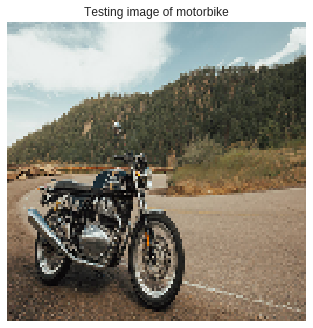

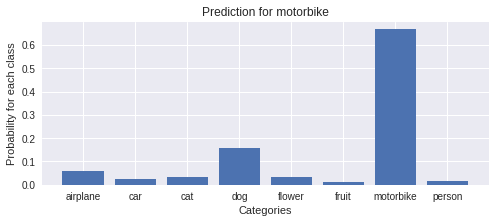

In [48]:
motorbike = gluon.utils.download(url = "https://www.royalenfield.com/content/dam/royal-enfield/usa/home/tout/best-looking-motorcycle.jpg")
image = transform(mx.image.imread(motorbike, flag = 1))
plt.imshow(image.transpose((1, 2, 0)).asnumpy())
plt.title('Testing image of motorbike')
plt.axis('off')
plt.show()


prediction = model(image.expand_dims(0).as_in_context(ctx)).softmax().asnumpy()[0]

probs = []
for prob in prediction:
    probs.append(prob)
plt.figure(figsize = (8,3))
plt.bar(categories, probs)
plt.title('Prediction for motorbike')
plt.xlabel('Categories')
plt.ylabel('Probability for each class')
plt.show()

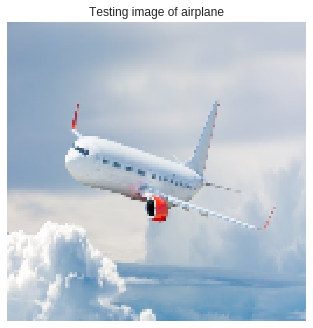

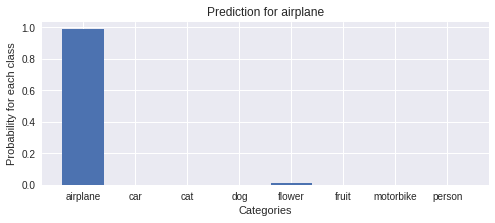

In [49]:
airplane = gluon.utils.download(url = "https://img1.grunge.com/img/gallery/the-real-reason-airplanes-are-almost-always-painted-white/intro-1567189774.jpg")
image = transform(mx.image.imread(airplane, flag = 1))
plt.imshow(image.transpose((1, 2, 0)).asnumpy())
plt.title('Testing image of airplane')
plt.axis('off')
plt.show()


prediction = model(image.expand_dims(0).as_in_context(ctx)).softmax().asnumpy()[0]

probs = []
for prob in prediction:
    probs.append(prob)
plt.figure(figsize = (8,3))
plt.bar(categories, probs)
plt.title('Prediction for airplane')
plt.xlabel('Categories')
plt.ylabel('Probability for each class')
plt.show()

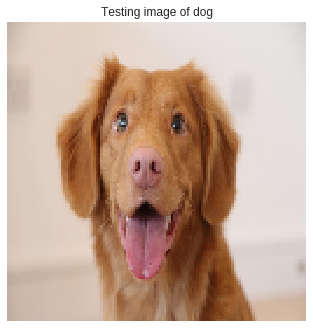

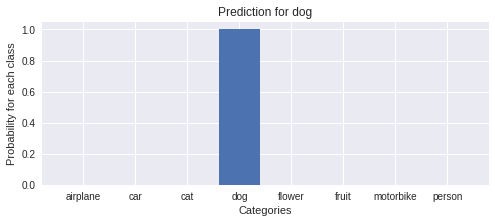

In [50]:
dog = gluon.utils.download(url = "https://i0.wp.com/cdn-prod.medicalnewstoday.com/content/images/articles/322/322868/golden-retriever-puppy.jpg?w=1155&h=1541")
image = transform(mx.image.imread(dog, flag = 1))
plt.imshow(image.transpose((1, 2, 0)).asnumpy())
plt.title('Testing image of dog')
plt.axis('off')
plt.show()


prediction = model(image.expand_dims(0).as_in_context(ctx)).softmax().asnumpy()[0]

probs = []
for prob in prediction:
    probs.append(prob)
plt.figure(figsize = (8,3))
plt.bar(categories, probs)
plt.title('Prediction for dog')
plt.xlabel('Categories')
plt.ylabel('Probability for each class')
plt.show()

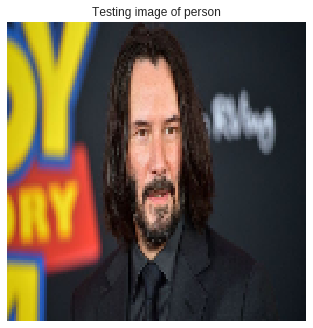

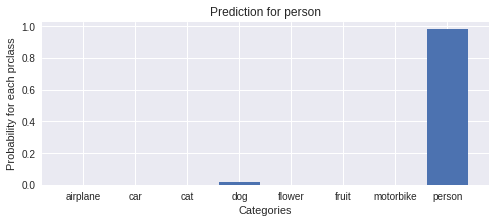

In [51]:
person = gluon.utils.download(url = "https://ca-times.brightspotcdn.com/dims4/default/7a68bed/2147483647/strip/true/crop/2048x1152+0+0/resize/840x473!/quality/90/?url=https%3A%2F%2Fcalifornia-times-brightspot.s3.amazonaws.com%2Fca%2Fe1%2F1cce3965c9a2b4f20aed93bd0b90%2Fla-1560957011-xf3aqvrdf1-snap-image")
image = transform(mx.image.imread(person, flag = 1))
plt.imshow(image.transpose((1, 2, 0)).asnumpy())
plt.title('Testing image of person')
plt.axis('off')
plt.show()


prediction = model(image.expand_dims(0).as_in_context(ctx)).softmax().asnumpy()[0]

probs = []
for prob in prediction:
    probs.append(prob)
plt.figure(figsize = (8,3))
plt.bar(categories, probs)
plt.title('Prediction for person')
plt.xlabel('Categories')
plt.ylabel('Probability for each prclass')
plt.show()

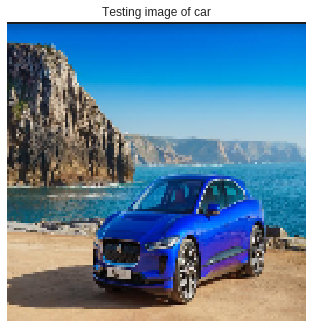

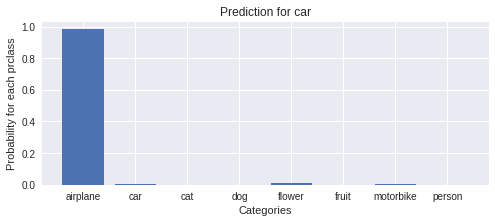

In [52]:
car = gluon.utils.download(url = "https://etimg.etb2bimg.com/photo/68706833.cms")
image = transform(mx.image.imread(car, flag = 1))
plt.imshow(image.transpose((1, 2, 0)).asnumpy())
plt.title('Testing image of car')
plt.axis('off')
plt.show()

prediction = model(image.expand_dims(0).as_in_context(ctx)).softmax().asnumpy()[0]

probs = []
for prob in prediction:
    probs.append(prob)
plt.figure(figsize = (8,3))
plt.bar(categories, probs)
plt.title('Prediction for car')
plt.xlabel('Categories')
plt.ylabel('Probability for each prclass')
plt.show()

## __ ^ That's wrong__

Since most of the airplane images of our dataset contained blue sky as a background, and this image of the car also contained massive blue ocean with blue sky as the background, therefore its falsely predicted!